In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install torch torchvision matplotlib numpy time psutil


ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
Note: you may need to restart the kernel to use updated packages.


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 15966334.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 471275.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 3804777.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2286703.73it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1, Average Loss: 46.3192
Epoch 1, Latency: 12.51s, Cost: 0.0064 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 35.1923
Epoch 2, Latency: 12.61s, Cost: 0.0064 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 33.1824
Epoch 3, Latency: 13.50s, Cost: 0.0059 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 32.2396
Epoch 4, Latency: 13.38s, Cost: 0.0060 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 31.6857
Epoch 5, Latency: 13.66s, Cost: 0.0059 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 31.3269
Epoch 6, Latency: 13.30s, Cost: 0.0060 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 31.0611
Epoch 7, Latency: 13.00s, Cost: 0.0062 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 30.8492
Epoch 8, Latency: 13.57s, Cost: 0.0059 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 30.6878
Epoch 9, Latency: 12.96s, Cost: 0.0062 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 30.5355
Epoch 10, Latency: 13.29s, Cost: 0.0060 GFLOPS, Energy: 0 J
Epoch 1, Average Loss: 3

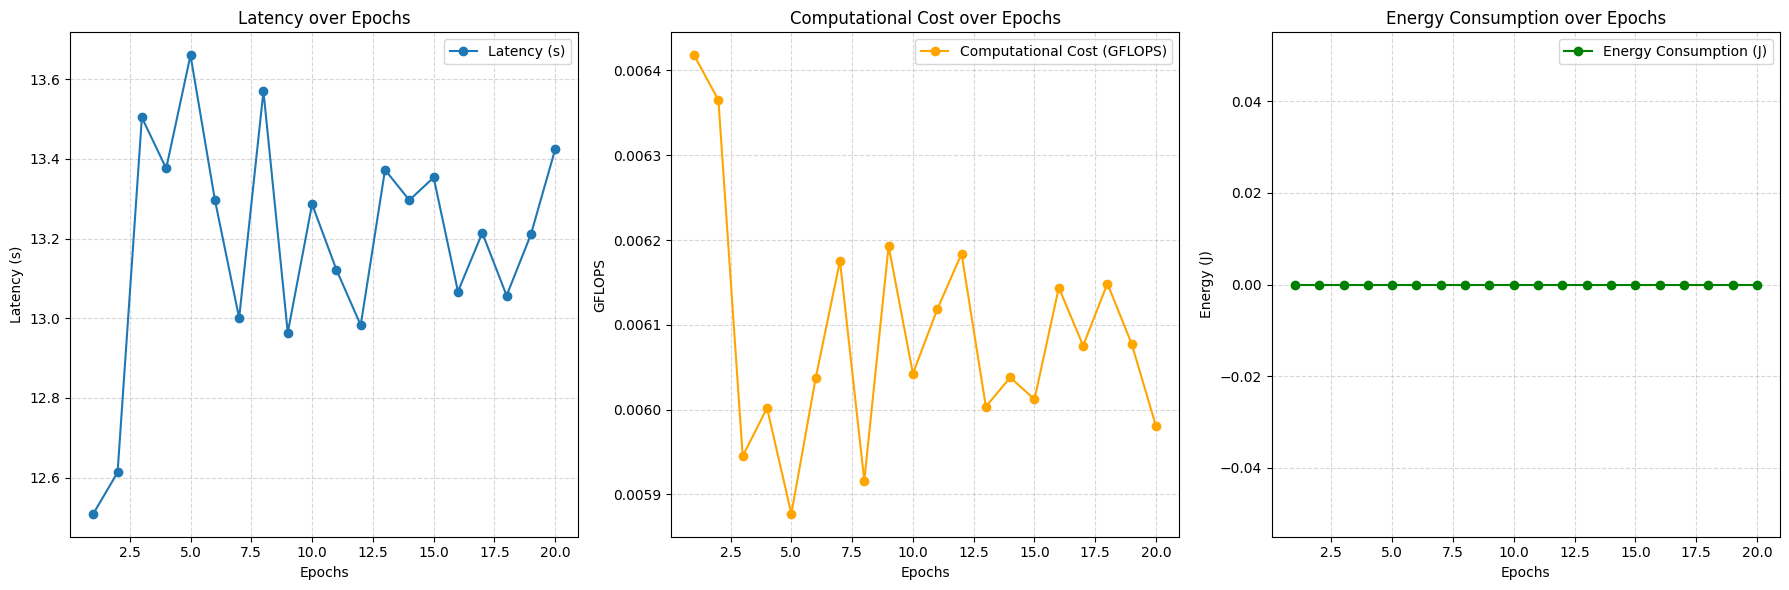

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import psutil
import time
import os
import numpy as np

# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE loss function
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Train the VAE
def train_vae(model, dataloader, optimizer, device, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}")

# Plot latency, computational cost, and energy consumption with more details
def plot_graphs(latency_list, comp_cost_list, energy_consumption_list):
    epochs = np.arange(1, len(latency_list) + 1)

    plt.figure(figsize=(18, 6))
    
    # Latency Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, latency_list, label='Latency (s)', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Latency (s)')
    plt.title('Latency over Epochs')
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.legend()

    # Computational Cost Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, comp_cost_list, label='Computational Cost (GFLOPS)', marker='o', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('GFLOPS')
    plt.title('Computational Cost over Epochs')
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.legend()

    # Energy Consumption Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, energy_consumption_list, label='Energy Consumption (J)', marker='o', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Energy (J)')
    plt.title('Energy Consumption over Epochs')
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Energy tracking with graceful handling
def get_initial_energy():
    try:
        battery = psutil.sensors_battery()
        return battery.energy_full if battery else 0
    except (FileNotFoundError, AttributeError):
        return None  # Gracefully handle missing battery info

def get_current_energy():
    try:
        battery = psutil.sensors_battery()
        return battery.energy_now if battery else 0
    except (FileNotFoundError, AttributeError):
        return None

# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_dim = 28 * 28  # MNIST images are 28x28
    hidden_dim = 400
    latent_dim = 20
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 20  # Increased epochs for more data points
    forgery_threshold = 2000  # Adjust based on data

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

    latency_list, comp_cost_list, energy_consumption_list = [], [], []

    initial_energy = get_initial_energy()

    for epoch in range(num_epochs):
        start_time = time.time()
        train_vae(vae, train_loader, optimizer, device, num_epochs=1)
        latency = time.time() - start_time
        latency_list.append(latency)

        comp_cost = (batch_size * input_dim * hidden_dim * 2) / (latency * 1e9)
        comp_cost_list.append(comp_cost)

        current_energy = get_current_energy()
        energy_consumed = (initial_energy - current_energy) if initial_energy and current_energy else 0
        energy_consumption_list.append(energy_consumed)

        print(f"Epoch {epoch + 1}, Latency: {latency:.2f}s, Cost: {comp_cost:.4f} GFLOPS, Energy: {energy_consumed} J")

    plot_graphs(latency_list, comp_cost_list, energy_consumption_list)

if __name__ == "__main__":
    main()


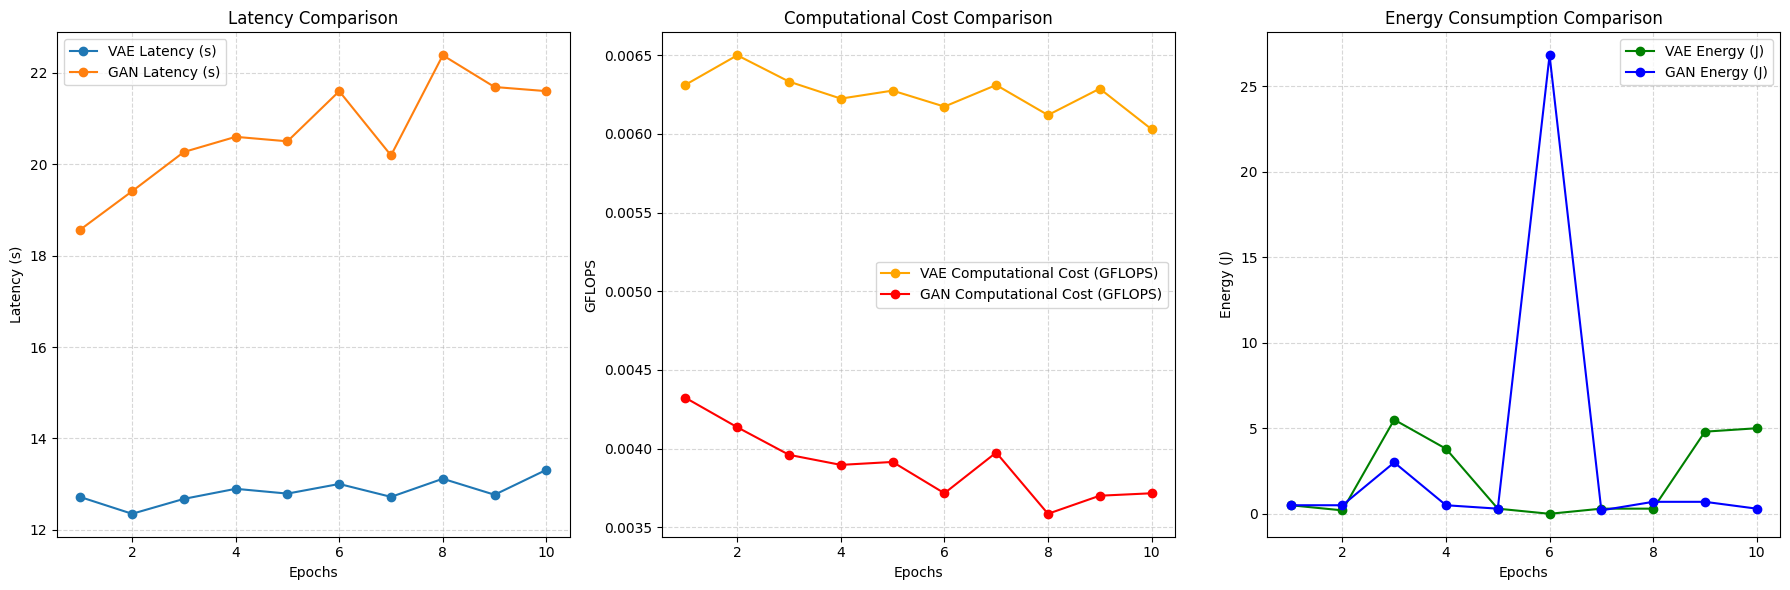

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import psutil
import time
import numpy as np

# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# GAN Model Definitions
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.fc(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# VAE Loss Function
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Training Functions
def train_vae(model, dataloader, optimizer, device, num_epochs=1):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

def train_gan(generator, discriminator, dataloader, optimizer_g, optimizer_d, device, latent_dim, num_epochs=1):
    criterion = nn.BCELoss()
    generator.train()
    discriminator.train()

    for _ in range(num_epochs):
        for real_data, _ in dataloader:
            real_data = real_data.view(real_data.size(0), -1).to(device)
            batch_size = real_data.size(0)

            # Train Discriminator
            optimizer_d.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_output = discriminator(real_data)
            real_loss = criterion(real_output, real_labels)

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            fake_output = discriminator(fake_data.detach())
            fake_loss = criterion(fake_output, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_output = discriminator(fake_data)
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            optimizer_g.step()

# Plotting Function
def plot_comparison(latency_vae, comp_cost_vae, energy_vae, latency_gan, comp_cost_gan, energy_gan):
    epochs = np.arange(1, len(latency_vae) + 1)

    plt.figure(figsize=(18, 6))

    # Latency Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, latency_vae, label='VAE Latency (s)', marker='o')
    plt.plot(epochs, latency_gan, label='GAN Latency (s)', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Latency (s)')
    plt.title('Latency Comparison')
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Computational Cost Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, comp_cost_vae, label='VAE Computational Cost (GFLOPS)', marker='o', color='orange')
    plt.plot(epochs, comp_cost_gan, label='GAN Computational Cost (GFLOPS)', marker='o', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('GFLOPS')
    plt.title('Computational Cost Comparison')
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Energy Consumption Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, energy_vae, label='VAE Energy (J)', marker='o', color='green')
    plt.plot(epochs, energy_gan, label='GAN Energy (J)', marker='o', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Energy (J)')
    plt.title('Energy Consumption Comparison')
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Energy Tracking Functions
def get_initial_energy():
    return psutil.cpu_percent(interval=1)

def get_current_energy():
    return psutil.cpu_percent(interval=1)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_dim = 28 * 28  # MNIST images are 28x28
    hidden_dim = 400
    latent_dim = 20
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 10

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize VAE
    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    optimizer_vae = optim.Adam(vae.parameters(), lr=learning_rate)

    # Initialize GAN
    generator = Generator(latent_dim, input_dim).to(device)
    discriminator = Discriminator(input_dim).to(device)
    optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

    # Performance Metrics
    latency_vae, comp_cost_vae, energy_vae = [], [], []
    latency_gan, comp_cost_gan, energy_gan = [], [], []

    # Initial Energy
    initial_energy = get_initial_energy()

    # Train VAE
    for epoch in range(num_epochs):
        start_time = time.time()
        loss_vae = train_vae(vae, train_loader, optimizer_vae, device)
        latency = time.time() - start_time
        latency_vae.append(latency)
        comp_cost_vae.append((batch_size * input_dim * hidden_dim * 2) / (latency * 1e9))
        energy_vae.append(get_current_energy() - initial_energy)

    # Train GAN
    for epoch in range(num_epochs):
        start_time = time.time()
        train_gan(generator, discriminator, train_loader, optimizer_g, optimizer_d, device, latent_dim)
        latency = time.time() - start_time
        latency_gan.append(latency)
        comp_cost_gan.append((batch_size * input_dim * hidden_dim * 2) / (latency * 1e9))
        energy_gan.append(get_current_energy() - initial_energy)

    # Plot Comparison
    plot_comparison(latency_vae, comp_cost_vae, energy_vae, latency_gan, comp_cost_gan, energy_gan)

if __name__ == "__main__":
    main()


Average MSE: 28.0600
Epoch 1, Latency: 12.38s, MSE: 28.0600, Memory Usage: 1.06 GB
Average MSE: 23.1702
Epoch 2, Latency: 13.14s, MSE: 23.1702, Memory Usage: 1.07 GB
Average MSE: 21.2483
Epoch 3, Latency: 13.15s, MSE: 21.2483, Memory Usage: 1.08 GB
Average MSE: 20.1639
Epoch 4, Latency: 12.73s, MSE: 20.1639, Memory Usage: 1.08 GB
Average MSE: 19.1902
Epoch 5, Latency: 12.91s, MSE: 19.1902, Memory Usage: 1.08 GB
Average MSE: 19.3926
Epoch 6, Latency: 13.16s, MSE: 19.3926, Memory Usage: 1.08 GB
Average MSE: 19.0520
Epoch 7, Latency: 12.89s, MSE: 19.0520, Memory Usage: 1.07 GB
Average MSE: 18.6831
Epoch 8, Latency: 12.94s, MSE: 18.6831, Memory Usage: 1.07 GB
Average MSE: 18.8045
Epoch 9, Latency: 13.28s, MSE: 18.8045, Memory Usage: 1.08 GB
Average MSE: 18.1732
Epoch 10, Latency: 12.79s, MSE: 18.1732, Memory Usage: 1.08 GB


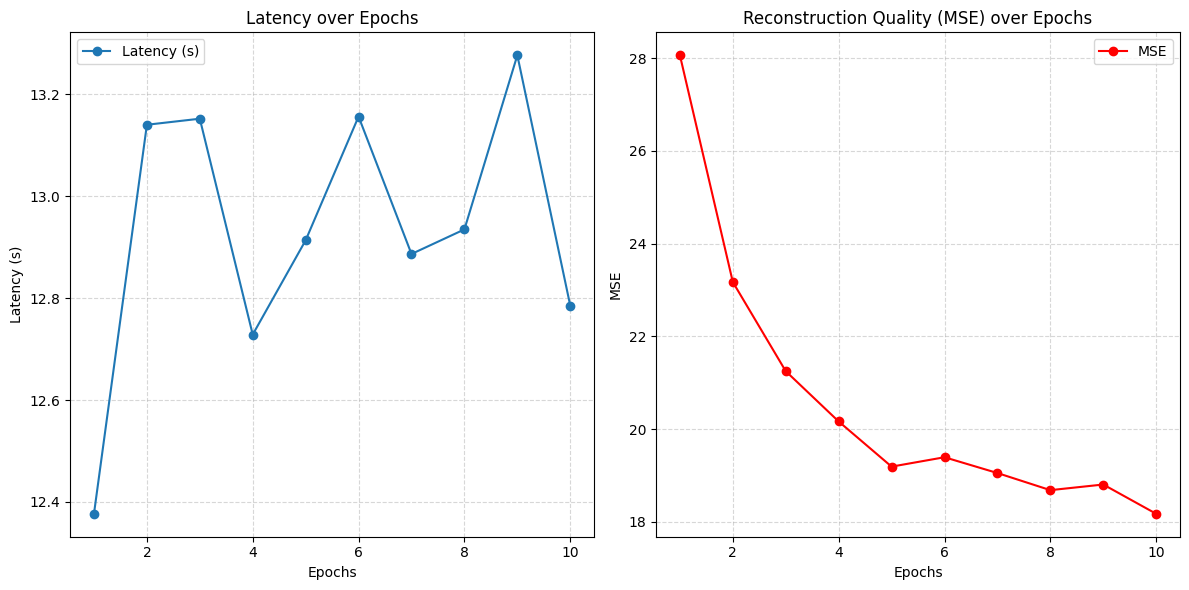

KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import psutil
import time
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import Image

# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE loss function
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Train the VAE
def train_vae(model, dataloader, optimizer, device, num_epochs=5):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

# Reconstruction Quality (MSE, SSIM, PSNR)
def compute_reconstruction_quality(model, dataloader, device):
    model.eval()
    total_mse = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.view(data.size(0), -1).to(device)
            recon_batch, _, _ = model(data)
            mse = nn.functional.mse_loss(recon_batch, data, reduction='sum').item()
            total_mse += mse

    avg_mse = total_mse / len(dataloader.dataset)
    print(f"Average MSE: {avg_mse:.4f}")
    # Add SSIM and PSNR calculations if needed
    return avg_mse

# Latent Space Visualization (t-SNE and PCA)
def visualize_latent_space(model, dataloader, device, latent_dim):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            data = data.view(data.size(0), -1).to(device)
            mu, _ = model.encode(data)
            latent_vectors.append(mu.cpu().numpy())
            labels.append(label.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(latent_vectors)
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', s=2)
    plt.colorbar()
    plt.title("t-SNE of Latent Space")
    plt.show()

    # PCA Visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', s=2)
    plt.colorbar()
    plt.title("PCA of Latent Space")
    plt.show()

# Memory Usage Tracking
def track_memory_usage():
    return psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB

# Main function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_dim = 28 * 28  # MNIST images are 28x28
    hidden_dim = 400
    latent_dim = 20
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 10

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

    latency_list, mse_list, memory_usage_list = [], [], []

    for epoch in range(num_epochs):
        # Measure latency
        start_time = time.time()
        avg_loss = train_vae(vae, train_loader, optimizer, device, num_epochs=1)
        latency = time.time() - start_time
        latency_list.append(latency)

        # Compute reconstruction quality
        avg_mse = compute_reconstruction_quality(vae, train_loader, device)
        mse_list.append(avg_mse)

        # Track memory usage
        memory_usage = track_memory_usage()
        memory_usage_list.append(memory_usage)

        print(f"Epoch {epoch + 1}, Latency: {latency:.2f}s, MSE: {avg_mse:.4f}, Memory Usage: {memory_usage:.2f} GB")

    # Plot Latency and MSE
    epochs = np.arange(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, latency_list, label='Latency (s)', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Latency (s)')
    plt.title('Latency over Epochs')
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, mse_list, label='MSE', marker='o', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Reconstruction Quality (MSE) over Epochs')
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Visualize Latent Space
    visualize_latent_space(vae, train_loader, device, latent_dim)

if __name__ == "__main__":
    main()


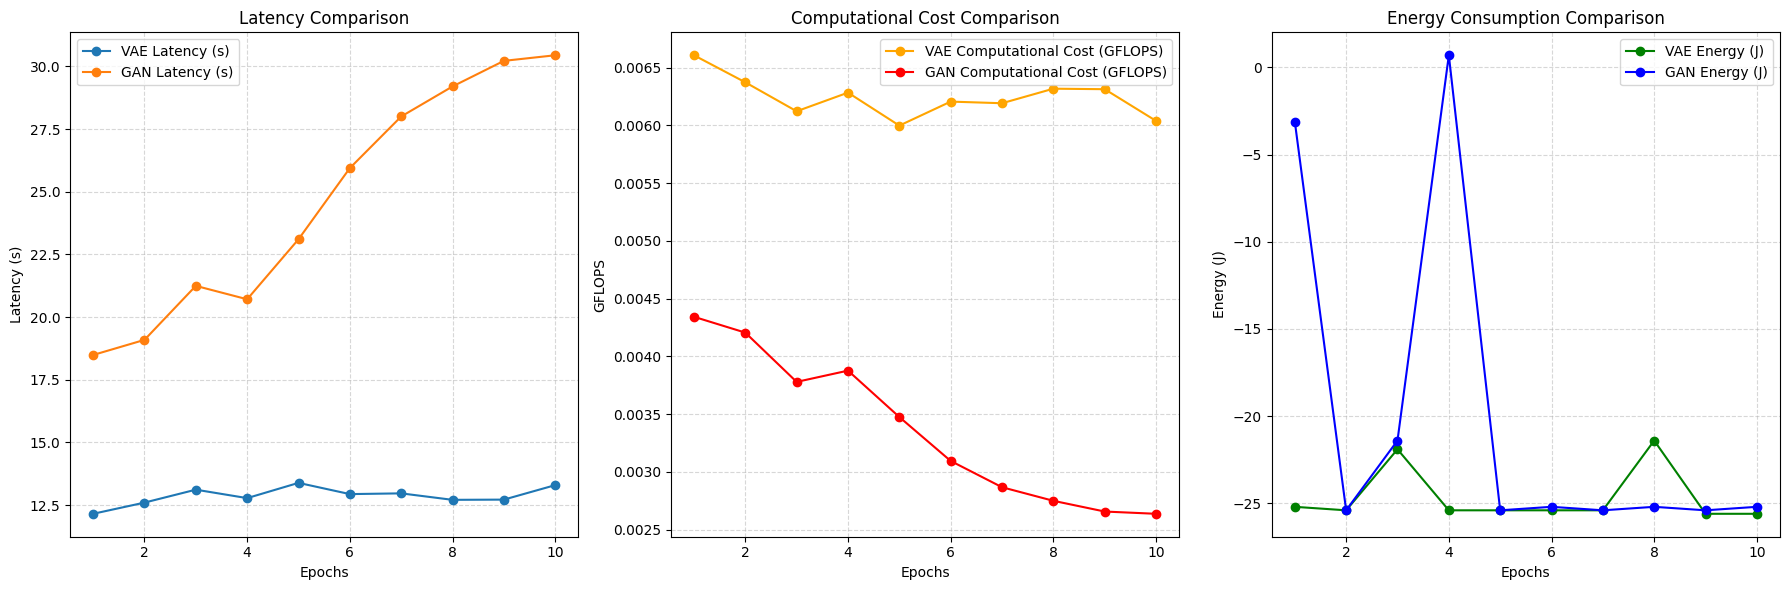

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import psutil
import time
import numpy as np

# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# GAN Model Definitions
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.fc(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# VAE Loss Function
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Training Functions
def train_vae(model, dataloader, optimizer, device, num_epochs=1):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

def train_gan(generator, discriminator, dataloader, optimizer_g, optimizer_d, device, latent_dim, num_epochs=1):
    criterion = nn.BCELoss()
    generator.train()
    discriminator.train()

    for _ in range(num_epochs):
        for real_data, _ in dataloader:
            real_data = real_data.view(real_data.size(0), -1).to(device)
            batch_size = real_data.size(0)

            # Train Discriminator
            optimizer_d.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_output = discriminator(real_data)
            real_loss = criterion(real_output, real_labels)

            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z)
            fake_output = discriminator(fake_data.detach())
            fake_loss = criterion(fake_output, fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            fake_output = discriminator(fake_data)
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            optimizer_g.step()

# Updated Plotting Function
def plot_comparison(latency_vae, comp_cost_vae, energy_vae, latency_gan, comp_cost_gan, energy_gan):
    epochs = np.arange(1, len(latency_vae) + 1)

    plt.figure(figsize=(18, 6))

    # Latency Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, latency_vae, label='VAE Latency (s)', marker='o')
    plt.plot(epochs, latency_gan, label='GAN Latency (s)', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Latency (s)')
    plt.title('Latency Comparison')
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.savefig('vae_gan_latency_comparison.png', dpi=300)

    # Computational Cost Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, comp_cost_vae, label='VAE Computational Cost (GFLOPS)', marker='o', color='orange')
    plt.plot(epochs, comp_cost_gan, label='GAN Computational Cost (GFLOPS)', marker='o', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('GFLOPS')
    plt.title('Computational Cost Comparison')
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.savefig('vae_gan_comp_cost_comparison.png', dpi=300)

    # Energy Consumption Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, energy_vae, label='VAE Energy (J)', marker='o', color='green')
    plt.plot(epochs, energy_gan, label='GAN Energy (J)', marker='o', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Energy (J)')
    plt.title('Energy Consumption Comparison')
    plt.legend()
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    plt.savefig('vae_gan_energy_comparison.png', dpi=300)

    plt.tight_layout()
    plt.show()


# Energy Tracking Functions
def get_initial_energy():
    return psutil.cpu_percent(interval=1)

def get_current_energy():
    return psutil.cpu_percent(interval=1)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_dim = 28 * 28  # MNIST images are 28x28
    hidden_dim = 400
    latent_dim = 20
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 10

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize VAE
    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    optimizer_vae = optim.Adam(vae.parameters(), lr=learning_rate)

    # Initialize GAN
    generator = Generator(latent_dim, input_dim).to(device)
    discriminator = Discriminator(input_dim).to(device)
    optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

    # Performance Metrics
    latency_vae, comp_cost_vae, energy_vae = [], [], []
    latency_gan, comp_cost_gan, energy_gan = [], [], []

    # Initial Energy
    initial_energy = get_initial_energy()

    # Train VAE
    for epoch in range(num_epochs):
        start_time = time.time()
        loss_vae = train_vae(vae, train_loader, optimizer_vae, device)
        latency = time.time() - start_time
        latency_vae.append(latency)
        comp_cost_vae.append((batch_size * input_dim * hidden_dim * 2) / (latency * 1e9))
        energy_vae.append(get_current_energy() - initial_energy)

    # Train GAN
    for epoch in range(num_epochs):
        start_time = time.time()
        train_gan(generator, discriminator, train_loader, optimizer_g, optimizer_d, device, latent_dim)
        latency = time.time() - start_time
        latency_gan.append(latency)
        comp_cost_gan.append((batch_size * input_dim * hidden_dim * 2) / (latency * 1e9))
        energy_gan.append(get_current_energy() - initial_energy)

    # Plot Comparison
    plot_comparison(latency_vae, comp_cost_vae, energy_vae, latency_gan, comp_cost_gan, energy_gan)

if __name__ == "__main__":
    main()
